In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
## Read files and data clean
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

In [9]:
## Read AVHRR data
satellite = "avhrr" 
df_avhrr = read_satellite_data(satellite)

In [10]:
df = df_avhrr#.sample(frac=1, random_state=8).reset_index(drop=True).iloc[0:500]

In [11]:
## Trend calculation (do not delete)
import pandas as pd
import re
import numpy as np
from scipy.stats import linregress

def calculate_trends_for_vars(df, variables):
    # Prepare results DataFrame with lat/lon copied from original df
    results = pd.DataFrame({
        "latitude": df["latitude"],
        "longitude": df["longitude"]
    }, index=df.index)
    
    for var in variables:
        # Define regex pattern based on variable name
        if var in ["sos", "eos"]:
            # Pattern matches e.g. sos_1982, eos_1990
            pattern = fr"^{var}_/d{{4}}$"
        else:
            # Pattern matches e.g. spring_t_1982, summer_p_2010
            pattern = fr"^{var}_/d{{4}}$"
        
        # Get columns matching this variable's pattern
        var_cols = [col for col in df.columns if re.match(pattern, col)]
        if not var_cols:
            print(f"No columns found for variable '{var}'. Skipping.")
            continue
        
        # Extract years from the last underscore part and sort columns accordingly
        years = [int(col.split("_")[-1]) for col in var_cols]
        var_cols, years = zip(*sorted(zip(var_cols, years), key=lambda x: x[1]))
        
        # Initialize Series for slopes and p-values (aligned to df index)
        slopes = pd.Series(np.nan, index=df.index)
        p_values = pd.Series(np.nan, index=df.index)
        
        # Calculate trend row-wise
        for i, row in df.iterrows():
            y_values = row[list(var_cols)].values
            mask = pd.notnull(y_values)
            if mask.sum() >= 2:
                # Only keep valid years and y_values for regression
                valid_years = [year for year, m in zip(years, mask) if m]
                valid_y = [y for y, m in zip(y_values, mask) if m]
                slope, intercept, r_value, p_value, std_err = linregress(valid_years, valid_y)
                slopes.at[i] = slope
                p_values.at[i] = p_value
        
        # Add results to DataFrame
        results[f"{var}_trend"] = slopes
        results[f"{var}_trend_p"] = p_values
    
    return results


In [12]:
df_trends = pd.read_csv("../data/trends/trend_df.csv")
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]
# print(df_trends)
years = [str(y) for y in range(1982, 2017)]
cols = years
df = df[[col for col in t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'/D*(/d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1) * 1000
df = df[['annual_t', 'annual_p', 'latitude', 'longitude']]
df = pd.merge(df, df_trends, on=['latitude', 'longitude'], how='inner') 

In [13]:
## Plot
import matplotlib.pyplot as plt
import numpy as np

def plot_trends_comparison(df1, df2, df3, title1='Cold-dry regions', title2='Hot-dry regions', title3='Wet regions'):
    groups = {
        "Trend of SOS & EOS (days/decade)": ['sos_trend', 'eos_trend'],
        "Trend of temperature (°C/decade)": [col for col in df1.columns if col.endswith('_trend') and '_t_' in col],
        "Trend of precipitation (mm/decade)": [col for col in df1.columns if col.endswith('_trend') and '_p_' in col],
        "Trend of radiation (MJ/m²/decade)": [col for col in df1.columns if col.endswith('_trend') and '_r_' in col],
    }

    colors = ['#4d91c4', '#d47264', 'gray']

    # Label mapping with exact case:
    label_map = {
        'sos': 'SOS',
        'eos': 'EOS',
        'spring_t': 'Spring T',
        'summer_t': 'Summer T',
        'autumn_t': 'Autumn T',
        'winter_t': 'Winter T',
        'spring_p': 'Spring P',
        'summer_p': 'Summer P',
        'autumn_p': 'Autumn P',
        'winter_p': 'Winter Prcp',
        'spring_r': 'Spring SR',
        'summer_r': 'Summer SR',
        'autumn_r': 'Autumn SR',
        'winter_r': 'Winter Rad',
        # Add more as needed
    }
    
    y_limits = {
        "Trend of SOS & EOS (days/decade)": (-15, 25),
        "Trend of temperature (°C/decade)": (-0.4, 1.5),
        "Trend of precipitation (mm/decade)": (-60, 60),
        "Trend of radiation (MJ/m²/decade)": (-0.6, 1.2),
    }

    def pretty_label(name):
        base = name.replace('_trend', '')
        if base in label_map:
            return label_map[base]
        else:
            return base.replace('_', ' ').title()

    plt.figure(figsize=(12, 12))

    all_legend_boxes = []
    all_legend_labels = [title1, title2, title3]

    for i, (group_name, cols) in enumerate(groups.items(), 1):
        ax = plt.subplot(2, 2, i)

        # Extract data
        data1 = [df1[col].dropna() for col in cols]
        data2 = [df2[col].dropna() for col in cols]
        data3 = [df3[col].dropna() for col in cols]

        # Apply multipliers according to group
        if "SOS & EOS" in group_name:
            factor = 10
        elif "temperature" in group_name:
            factor = 10
        elif "precipitation" in group_name:
            factor = 10000
        elif "radiation" in group_name:
            factor = 1/100000
        else:
            factor = 1

        data1 = [d * factor for d in data1]
        data2 = [d * factor for d in data2]
        data3 = [d * factor for d in data3]

        labels = [pretty_label(col) for col in cols]

        n = len(cols)
        positions_1 = np.arange(1, n * 3, 3)        # positions for df1
        positions_2 = positions_1 + 0.8             # df2
        positions_3 = positions_1 + 1.6             # df3
        ax.set_ylim(y_limits[group_name])

        bpl = ax.boxplot(data1, positions=positions_1, widths=0.4, patch_artist=True,
                         boxprops=dict(facecolor=colors[0], linewidth=0.7),
                         showfliers=False,
                         whiskerprops=dict(color='black', linewidth=0.7),
                         capprops=dict(visible=False),
                         medianprops=dict(color='black', linewidth=0.7))  # thinner median line
        
        bpr = ax.boxplot(data2, positions=positions_2, widths=0.4, patch_artist=True,
                         boxprops=dict(facecolor=colors[1], linewidth=0.7),
                         showfliers=False,
                         whiskerprops=dict(color='black', linewidth=0.7),
                         capprops=dict(visible=False),
                         medianprops=dict(color='black', linewidth=0.7))
        
        bpt = ax.boxplot(data3, positions=positions_3, widths=0.4, patch_artist=True,
                         boxprops=dict(facecolor=colors[2], linewidth=0.7),
                         showfliers=False,
                         whiskerprops=dict(color='black', linewidth=0.7),
                         capprops=dict(visible=False),
                         medianprops=dict(color='black', linewidth=0.7))

        # Plot mean markers and values
        for bplot, dataset_data, positions in zip([bpl, bpr, bpt], [data1, data2, data3], [positions_1, positions_2, positions_3]):
            whiskers = bplot['whiskers']
            n_boxes = len(dataset_data)
            for idx in range(n_boxes):
                pos = positions[idx]
                vals = dataset_data[idx]
                mean_val = np.mean(vals)
                ax.plot(pos, mean_val, marker='x', color='black', markersize=6, markeredgewidth=1)  # thinner mean marker

                whisker_line = whiskers[2*idx + 1]
                ydata = whisker_line.get_ydata()
                max_whisker = max(ydata)
                # Add a small offset above whisker, scaled by y-range:
                y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
                offset = 0.03 * y_range
                y_text = max_whisker + offset
                ax.text(pos, y_text, f"{mean_val:.2f}", ha='center', va='bottom', fontsize=12, color='black')  # bigger mean text


        ax.set_xticks(positions_1 + 0.8)
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
        ax.set_ylabel(group_name, fontsize=14)
        # ax.set_xlabel('Variables', fontsize=14)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.grid(False)
        ax.tick_params(axis='y', labelsize=12)

        # Save one box for legend from first group only
        if i == 1:
            all_legend_boxes = [bpl["boxes"][0], bpr["boxes"][0], bpt["boxes"][0]]

    plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space at bottom for legend

    import matplotlib.patches as mpatches
    
    # Create legend handles as rectangles
    handles = [
        mpatches.Patch(color='#4d91c4', label=title1),
        mpatches.Patch(color='#d47264', label=title2),
        mpatches.Patch(color='gray',    label=title3),
    ]
    
    fig = plt.gcf()
    fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=12, 
               frameon=False, bbox_to_anchor=(0.5, 0.02))

    return fig
    # plt.show()


In [ ]:
## Divide into three regions
df_wet = df[df['annual_p']>900]
df_cold_dry = df[(df['annual_t']>7.25) & (df['annual_p']<900)]
df_hot_dry = df[(df['annual_t']<7.25) & (df['annual_p']<900)]

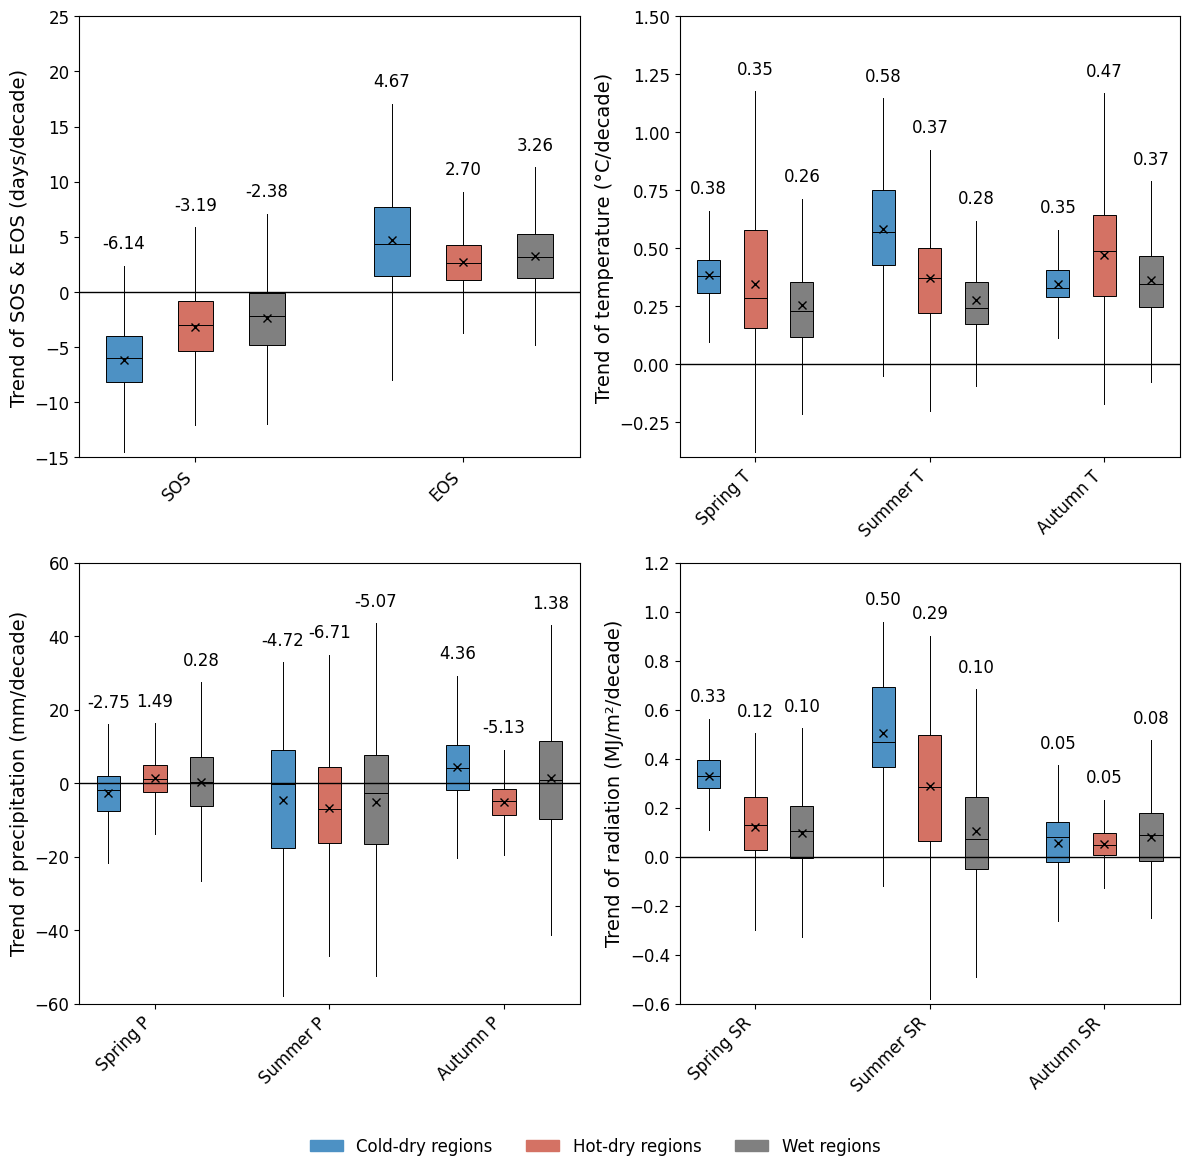

In [14]:
fig = plot_trends_comparison(df_cold_dry, df_hot_dry, df_wet)
fig.savefig("../results/si_figures/si_fig11/trends.png", dpi=300, bbox_inches='tight')

In [92]:
## Plot fig S10b (SPRUCE)

In [93]:
## Read SPRUCE with only seasonal temp
import pandas as pd
import glob
import os
import numpy as np
# ==== 1. Read and Concatenate CSVs ====
base_dir = r"../data/spruce_data/WEW_Complete_Environ_20250311"
file_paths = glob.glob(os.path.join(base_dir, "*Complete_Environ_20250311.csv"))

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, comment='#')
    df = df[['TIMESTAMP', 'TA_2_0_1', 'Plot', 'Temp_target', 'CO2_trmt']]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# ==== 2. Parse timestamps ====
data['timestamp'] = pd.to_datetime(data['TIMESTAMP'].str.strip(), errors='coerce')
mask = data['timestamp'].isna()
if mask.any():
    data.loc[mask, 'timestamp_str'] = data.loc[mask, 'TIMESTAMP'].str.strip()
    data.loc[mask, 'timestamp_extracted'] = data.loc[mask, 'timestamp_str'].str.extract(
        r'(/d{4}-/d{2}-/d{2} /d{2}:/d{2}:/d{2})', expand=False
    )
    data.loc[mask, 'timestamp'] = pd.to_datetime(data.loc[mask, 'timestamp_extracted'], errors='coerce')

# ==== 3. Drop NAs ====
# data_clean = data.dropna(subset=['timestamp', 'TA_2_0_1'])
data_clean = data.dropna(subset=['timestamp', 'TA_2_0_1']).copy()
data_clean.replace(-9999, np.nan, inplace=True)
# data_clean



# ==== 4. Extract time components ====
data_clean['plot'] = data_clean['Plot']  # Consistent lowercase
data_clean['year'] = data_clean['timestamp'].dt.year
data_clean['month'] = data_clean['timestamp'].dt.month
data_clean['day'] = data_clean['timestamp'].dt.day

# # ==== 5. Annual Mean Temperature ====
# df_annual = data_clean.groupby(['year', 'plot'])['TA_2_0_1'].mean().reset_index()
# df_annual.rename(columns={'TA_2_0_1': 'annual_temp'}, inplace=True)
# pivot_annual = df_annual.pivot(index="plot", columns="year", values="annual_temp")
# pivot_annual.columns = [f"annual_temp_{int(year)}" for year in pivot_annual.columns]
# df_envir = pivot_annual.reset_index()

# # ==== 6. Define seasons ====
# def get_season(row):
#     month = row['month']
#     day = row['day']
#     if (month == 3 and day >= 1) or (3 < month < 6) or (month == 6 and day < 1):
#         return 'spring'
#     elif (month == 6 and day >= 1) or (6 < month < 9) or (month == 9 and day < 1):
#         return 'summer'
#     elif (month == 9 and day >= 1) or (9 < month < 12) or (month == 12 and day < 1):
#         return 'autumn'
#     else:
#         return None  # Outside defined seasons

# data_clean['season'] = data_clean.apply(get_season, axis=1)
# data_seasonal = data_clean.dropna(subset=['season'])

# # ==== 7. Seasonal Mean Temperatures ====
# seasonal_temp = data_seasonal.groupby(['year', 'plot', 'season'])['TA_2_0_1'].mean().reset_index()
# seasonal_pivot = seasonal_temp.pivot_table(index='plot', columns=['season', 'year'], values='TA_2_0_1')
# seasonal_pivot.columns = [f"{season}_t_{year}" for season, year in seasonal_pivot.columns]
# df_seasonal = seasonal_pivot.reset_index()

# # ==== 8. Combine Annual + Seasonal ====
# df_envir = df_envir.merge(df_seasonal, on='plot', how='outer')

# # ==== 9. (Optional) Sort columns by year for readability ====
# sorted_cols = ['plot'] + sorted([col for col in df_envir.columns if col != 'plot'])
# df_envir = df_envir[sorted_cols]
# df_envir
# # ==== 10. Output preview ====
# # print(df_envir.head())

# ==== 5. Annual Mean Temperature (Dec 1 last year → Nov 30 this year) ====

# create year window: "EOS year"
data_clean["eos_year"] = np.where(
    (data_clean["month"] == 12),
    data_clean["year"] + 1,   # Dec belongs to next EOS cycle
    data_clean["year"]
)

# keep only Dec 1 → Nov 30
def in_eos_window(ts):
    m = ts.month
    d = ts.day
    if m == 12 and d >= 1:
        return True
    if 1 <= m <= 11:
        return True
    return False

data_clean = data_clean[data_clean["timestamp"].apply(in_eos_window)]

# group by EOS year
df_annual = (
    data_clean
    .groupby(["eos_year", "plot"])["TA_2_0_1"]
    .mean()
    .reset_index()
)

df_annual.rename(columns={"TA_2_0_1": "annual_t", "eos_year": "year"}, inplace=True)

pivot_annual = df_annual.pivot(index="plot", columns="year", values="annual_t")
pivot_annual.columns = [f"annual_t_{int(year)}" for year in pivot_annual.columns]
df_envir = pivot_annual.reset_index()


In [94]:
## Read ORNL PhenoCam data 25% rising and falling
import pandas as pd
import numpy as np

## ORNL PhenoCam data
df = pd.read_csv("../data/spruce_data/ORNL_PhenoCam/Phenology_TransitionDates_3day_2015_2023.csv")

# Create SOS dataframe for 'rising' direction
sos_df = df[df['direction'] == 'rising'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "sos_"
sos_df.columns = ['sos_' + str(col) for col in sos_df.columns]
sos_df = sos_df.reset_index()

# Create EOS dataframe for 'falling' direction
eos_df = df[df['direction'] == 'falling'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "eos_"
eos_df.columns = ['eos_' + str(col) for col in eos_df.columns]
eos_df = eos_df.reset_index()

# Merge the two dataframes on veg_type and plot
result_df = pd.merge(sos_df, eos_df, on=['veg_type', 'plot'], how='outer')

## Only to generate table for model
df = result_df.merge(df_envir, on="plot", how="inner")
# df.to_csv("")

# print(result_df)
# veg_type = "SH"
# df_pheno = result_df[result_df["veg_type"] == veg_type]

df_pheno = result_df

df_pheno = df_pheno.merge(df_envir, on="plot", how="inner")
elevated_plots = [4, 10, 11, 16, 19]
df_pheno['co2_level'] = np.where(df_pheno['plot'].isin(elevated_plots), 'elevated', 'ambient')
df_pheno = df_pheno[df_pheno["co2_level"] == "ambient"]
# print(df_pheno.shape)
# print(df_pheno.head())
# print(15*9)
eos_cols = df_pheno.loc[:, df_pheno.columns.str.contains('eos')]
# eos_cols

In [95]:
## Combine prcp_rad with df_pheno
prcp_rad = pd.read_csv("../data/spruce_data/prcp_rad/prcp_rad.csv")
for col in prcp_rad.columns:
    df_pheno[col] = prcp_rad.iloc[0][col]

In [96]:
## Combine prcp_rad with df_pheno
wt = pd.read_csv("../data/spruce_data/water_table/wt.csv")
df_pheno = df_pheno.merge(wt, on="plot", how="left")

In [97]:
def reshape_phenology_data(df):
    import pandas as pd

    years = [str(y) for y in range(2016, 2024)]

    var_names = [
        'eos', 'sos',
        'annual_t',
        'annual_p',
        'annual_r',
        'annual_w'
    ]

    long_rows = []

    for idx, row in df.iterrows():
        for y in years:
            row_data = {
                'plot': row['plot'],
                'veg_type': row['veg_type'],
                'year': int(y)
            }

            for var in var_names:
                colname = f'{var}_{y}'
                if colname in df.columns:
                    row_data[var] = row[colname]
                else:
                    row_data[var] = None  # fill with None/NaN if column missing

            # Skip if all variables are missing (optional)
            if any(pd.notna(row_data[var]) for var in var_names):
                long_rows.append(row_data)

    return pd.DataFrame(long_rows)


In [98]:
reshaped_df_pheno = reshape_phenology_data(df_pheno)#.dropna()
reshaped_df_pheno#.to_csv('test.csv')

,plot,veg_type,year,eos,sos,annual_t,annual_p,annual_r,annual_w
0,6,DN,2016,287.0,116.0,8.706125,0.803069,12796608.0,0.022675
1,6,DN,2017,284.0,116.0,7.060002,0.883853,13184055.0,-0.025105
2,6,DN,2018,290.0,124.0,5.986332,0.871656,13704988.0,-0.082710
3,6,DN,2019,287.0,123.0,5.677327,0.885450,12972382.0,-0.060745
4,6,DN,2020,285.0,123.0,6.898679,0.600380,14210540.0,-0.009058
...,...,...,...,...,...,...,...,...,...
115,20,SH,2019,301.0,129.0,7.539070,0.885450,12972382.0,-0.068674
116,20,SH,2020,293.0,141.0,8.788102,0.600380,14210540.0,-0.040909
117,20,SH,2021,310.0,134.0,10.150157,0.616644,14108788.0,-0.128047
118,20,SH,2022,296.0,133.0,7.303673,0.851572,13463019.0,-0.053342


In [99]:
## Per plot & per veg type effect

In [100]:
from econml.dml import LinearDML
from sklearn.linear_model import LinearRegression

def sensitivity_mean_env_and_sos_causal(long_df, verbose=True, min_samples=5):
    import pandas as pd
    import numpy as np

    long_df = long_df.copy()

    # Add annual_w here
    predictors = ['sos', 'annual_t', 'annual_p', 'annual_r', 'annual_w']
    results = []

    def scale(series):
        min_val, max_val = series.min(), series.max()
        if max_val - min_val < 1e-6:
            return pd.Series(0.0, index=series.index)
        return 2 * (series - min_val) / (max_val - min_val) - 1

    for (plot, veg_type), group in long_df.groupby(['plot', 'veg_type']):
        df = group.dropna(subset=predictors + ['eos']).copy()
        if len(df) < min_samples:
            continue

        df['eos'] = scale(df['eos'])
        df[predictors] = df[predictors].apply(scale)
        Y = df['eos'].to_numpy().ravel()

        for treat_var in predictors:
            T = df[treat_var].to_numpy().ravel()
            control_vars = [v for v in predictors if v != treat_var]
            W = df[control_vars].to_numpy()

            try:
                cf = LinearDML(
                    model_y=LinearRegression(),
                    model_t=LinearRegression(),
                    discrete_treatment=False,
                    random_state=42
                )
                cf.fit(Y, T, W=W)
                effect = float(cf.ate())
                p_value = float(cf.ate_inference().pvalue())

                results.append({
                    'plot': plot,
                    'veg_type': veg_type,
                    'variable': treat_var,
                    'effect': effect,
                    'p_value': p_value,
                    'n_obs': len(df),
                    'method': 'LinearDML'
                })

                if verbose and abs(effect) > 0.5:
                    print(f"⚠️ Strong causal effect | plot={plot}, veg={veg_type}, var={treat_var}, ATE={effect:.3f}, p={p_value:.3f}")

            except Exception as e:
                if verbose:
                    print(f"❌ DML failed for {plot}-{veg_type}-{treat_var}: {e}")

                results.append({
                    'plot': plot,
                    'veg_type': veg_type,
                    'variable': treat_var,
                    'effect': np.nan,
                    'p_value': np.nan,
                    'n_obs': len(df),
                    'method': 'LinearDML'
                })

    return pd.DataFrame(results)


In [101]:
effect_df = sensitivity_mean_env_and_sos_causal(reshaped_df_pheno)

⚠️ Strong causal effect | plot=6, veg=DN, var=sos, ATE=2.307, p=0.004
⚠️ Strong causal effect | plot=6, veg=DN, var=annual_t, ATE=0.949, p=0.010
⚠️ Strong causal effect | plot=6, veg=DN, var=annual_p, ATE=0.627, p=0.080
⚠️ Strong causal effect | plot=6, veg=DN, var=annual_r, ATE=-0.545, p=0.502
⚠️ Strong causal effect | plot=6, veg=EN, var=sos, ATE=1.021, p=0.020
⚠️ Strong causal effect | plot=6, veg=EN, var=annual_p, ATE=-0.502, p=0.412
⚠️ Strong causal effect | plot=6, veg=EN, var=annual_r, ATE=-0.700, p=0.268
⚠️ Strong causal effect | plot=6, veg=EN, var=annual_w, ATE=1.079, p=0.081
⚠️ Strong causal effect | plot=6, veg=SH, var=annual_p, ATE=-0.694, p=0.015
⚠️ Strong causal effect | plot=6, veg=SH, var=annual_w, ATE=-0.852, p=0.000
⚠️ Strong causal effect | plot=8, veg=DN, var=annual_p, ATE=-1.228, p=0.097
⚠️ Strong causal effect | plot=8, veg=DN, var=annual_r, ATE=-0.522, p=0.288
⚠️ Strong causal effect | plot=8, veg=EN, var=annual_t, ATE=0.866, p=0.107
⚠️ Strong causal effect | pl

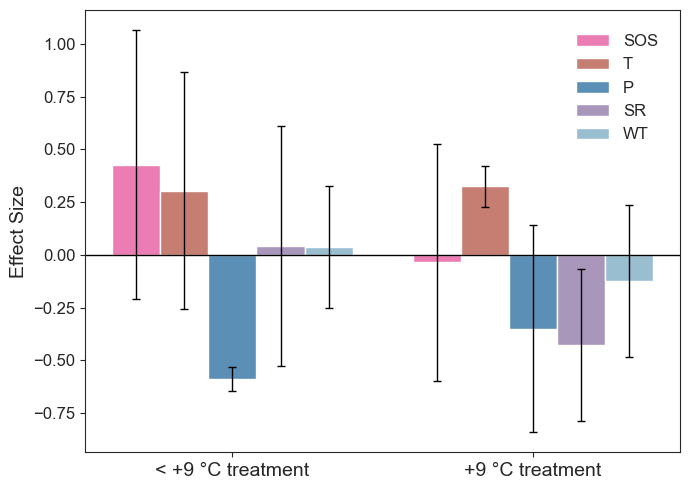

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predictor list (must match effect_df["variable"])
predictors = ['sos', 'annual_t', 'annual_p', 'annual_r', 'annual_w']

# Updated color map (WT = distinct blue)
color_map = {
    'sos': '#ff69b4',      # pink
    'annual_t': '#d47264', # red-ish
    'annual_p': '#4d91c4', # medium blue
    'annual_r': '#a991c1', # purple
    'annual_w': '#8ec1da'  # deep blue for WT
}

# Pretty legend labels
legend_labels = {
    'sos': 'SOS',
    'annual_t': 'T',
    'annual_p': 'P',
    'annual_r': 'SR',
    'annual_w': 'WT'
}

# Groups
group1_plots = [8]
group2_plots = [17]

# Function to compute mean ± SE
def mean_se(df):
    mean = df['effect'].mean()
    se = df['effect'].std(ddof=1) / np.sqrt(len(df))
    return pd.Series({'mean': mean, 'se': se})

# Group 1 stats (✓ Fixed include_groups=False)
group1_stats = (
    effect_df[effect_df['plot'].isin(group1_plots)]
    .groupby('variable')
    .apply(mean_se, include_groups=False)
    .reset_index()
)
group1_stats['group'] = 'Group 1 (6, 20, 13, 8)'

# Group 2 stats (✓ Fixed include_groups=False)
group2_stats = (
    effect_df[effect_df['plot'].isin(group2_plots)]
    .groupby('variable')
    .apply(mean_se, include_groups=False)
    .reset_index()
)
group2_stats['group'] = 'Group 2 (17)'

# Combine groups
combined_stats = pd.concat([group1_stats, group2_stats], ignore_index=True)
combined_stats['variable'] = pd.Categorical(combined_stats['variable'], categories=predictors, ordered=True)

# Plotting
plt.figure(figsize=(7, 5))
sns.set_style("ticks")

# Bar plot
ax = sns.barplot(
    data=combined_stats,
    x='group',
    y='mean',
    hue='variable',
    palette=color_map,
    hue_order=predictors,
    order=['Group 1 (6, 20, 13, 8)', 'Group 2 (17)'],
    dodge=True
)

# Error bars
for bar, (_, row) in zip(ax.patches, combined_stats.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    se = row['se']
    ax.errorbar(x, y, yerr=se, fmt='none', ecolor='black', capsize=3, capthick=1, linewidth=1)

# Replace x-tick labels (✓ Warning removed)
xtick_labels = {
    'Group 1 (6, 20, 13, 8)': '< +9 °C treatment',
    'Group 2 (17)': '+9 °C treatment'
}

labels = [xtick_labels.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels, fontsize=14)

# Y-axis
ax.tick_params(axis='y', labelsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels.get(label, label) for label in labels]
ax.legend(
    handles, new_labels,
    title="",
    title_fontsize=12,
    fontsize=12,
    loc='upper left', bbox_to_anchor=(0.8, 0.98),
    frameon=False
)

plt.xlabel("", fontsize=14)
plt.ylabel("Effect Size", fontsize=14)
plt.tight_layout()

plt.savefig("../results/figure3/spruce.jpg", dpi=300, bbox_inches='tight')
plt.show()
